In [1]:
import os
import math
import pickle
import torch
import optuna
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# 获取所有图像路径，递归查找
data = glob(r'/root/autodl-tmp/fingerprints/fingerprints/DB*/**/*.tif', recursive=True)
images = []

# 读取图像
def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")
        try:
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            images.append(np.array(img))
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")
    return images

images = readImages(data)
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 预处理图像数据
images_arr = np.asarray(images).astype('float32') / 255.0
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(
    images_arr, images_arr, test_size=0.2, random_state=13
)

# 转换为PyTorch张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)
train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建数据加载器
train_loader = DataLoader(TensorDataset(train_X, train_ground), batch_size=128, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_ground), batch_size=128, shuffle=False)

尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_8.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_5.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_5

In [2]:
# 定义ExLU激活函数
class ExLU(nn.Module):
    def __init__(self, seqFlag, trial):
        super(ExLU, self).__init__()
        self.sigma = nn.Parameter(
            torch.tensor(trial.suggest_float(f'sigma_{seqFlag}', 0, 6.0), dtype=torch.float32)
        )

    def forward(self, x):
        return torch.where(x >= 0, x, x * torch.exp(x / self.sigma))

# 定义自动编码器模型
class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), ExLU(1, trial), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), ExLU(2, trial), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), ExLU(3, trial)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1), ExLU(4, trial), nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1), ExLU(5, trial), nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

# 使用GPU（如可用）
device = torch.device("cuda")

# 定义训练函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss, valid_loss = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        valid_loss.append(val_loss / len(valid_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

    return train_loss, valid_loss

# 定义Optuna目标函数
def objective(trial):
    model = Autoencoder(trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, valid_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300)
    return valid_loss[-1]

# 使用Optuna进行超参数优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# 获取最佳参数并重新训练模型
best_params = study.best_params
print("最佳参数: ", best_params)

[I 2024-10-14 15:38:50,166] A new study created in memory with name: no-name-ca2ba5fc-b842-4e1c-b00f-0e8be7d82213


Epoch 1, Training Loss: 0.0648, Validation Loss: 0.0655
Epoch 2, Training Loss: 0.0614, Validation Loss: 0.0567
Epoch 3, Training Loss: 0.0491, Validation Loss: 0.0433
Epoch 4, Training Loss: 0.0376, Validation Loss: 0.0319
Epoch 5, Training Loss: 0.0255, Validation Loss: 0.0246
Epoch 6, Training Loss: 0.0244, Validation Loss: 0.0255
Epoch 7, Training Loss: 0.0225, Validation Loss: 0.0208
Epoch 8, Training Loss: 0.0183, Validation Loss: 0.0197
Epoch 9, Training Loss: 0.0182, Validation Loss: 0.0211
Epoch 10, Training Loss: 0.0189, Validation Loss: 0.0203
Epoch 11, Training Loss: 0.0179, Validation Loss: 0.0193
Epoch 12, Training Loss: 0.0176, Validation Loss: 0.0195
Epoch 13, Training Loss: 0.0179, Validation Loss: 0.0192
Epoch 14, Training Loss: 0.0176, Validation Loss: 0.0185
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0182
Epoch 16, Training Loss: 0.0167, Validation Loss: 0.0182
Epoch 17, Training Loss: 0.0168, Validation Loss: 0.0182
Epoch 18, Training Loss: 0.0166, Validat

[I 2024-10-14 15:41:42,213] Trial 0 finished with value: 0.003215424483641982 and parameters: {'sigma_1': 3.9857801703757803, 'sigma_2': 2.3867221272704446, 'sigma_3': 0.916081409474502, 'sigma_4': 1.3205057459216163, 'sigma_5': 1.7256141239829923}. Best is trial 0 with value: 0.003215424483641982.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0032
Epoch 1, Training Loss: 0.0646, Validation Loss: 0.0720
Epoch 2, Training Loss: 0.0574, Validation Loss: 0.0464
Epoch 3, Training Loss: 0.0393, Validation Loss: 0.0371
Epoch 4, Training Loss: 0.0317, Validation Loss: 0.0259
Epoch 5, Training Loss: 0.0293, Validation Loss: 0.0227
Epoch 6, Training Loss: 0.0212, Validation Loss: 0.0232
Epoch 7, Training Loss: 0.0208, Validation Loss: 0.0246
Epoch 8, Training Loss: 0.0216, Validation Loss: 0.0200
Epoch 9, Training Loss: 0.0180, Validation Loss: 0.0210
Epoch 10, Training Loss: 0.0184, Validation Loss: 0.0213
Epoch 11, Training Loss: 0.0185, Validation Loss: 0.0186
Epoch 12, Training Loss: 0.0173, Validation Loss: 0.0196
Epoch 13, Training Loss: 0.0175, Validation Loss: 0.0197
Epoch 14, Training Loss: 0.0172, Validation Loss: 0.0182
Epoch 15, Training Loss: 0.0164, Validation Loss: 0.0187
Epoch 16, Training Loss: 0.0168, Validation Loss: 0.0187
Epoch 17, Training Loss: 0.0165, Valida

[I 2024-10-14 15:44:32,119] Trial 1 finished with value: 0.0034081756602972746 and parameters: {'sigma_1': 5.241917698005655, 'sigma_2': 5.480929136692435, 'sigma_3': 0.8191777595942806, 'sigma_4': 4.450618641962568, 'sigma_5': 3.59535972660259}. Best is trial 0 with value: 0.003215424483641982.


Epoch 300, Training Loss: 0.0030, Validation Loss: 0.0034
Epoch 1, Training Loss: 0.0645, Validation Loss: 0.0625
Epoch 2, Training Loss: 0.0553, Validation Loss: 0.0544
Epoch 3, Training Loss: 0.0456, Validation Loss: 0.0322
Epoch 4, Training Loss: 0.0279, Validation Loss: 0.0242
Epoch 5, Training Loss: 0.0235, Validation Loss: 0.0248
Epoch 6, Training Loss: 0.0230, Validation Loss: 0.0207
Epoch 7, Training Loss: 0.0185, Validation Loss: 0.0219
Epoch 8, Training Loss: 0.0191, Validation Loss: 0.0209
Epoch 9, Training Loss: 0.0192, Validation Loss: 0.0190
Epoch 10, Training Loss: 0.0175, Validation Loss: 0.0199
Epoch 11, Training Loss: 0.0178, Validation Loss: 0.0200
Epoch 12, Training Loss: 0.0181, Validation Loss: 0.0185
Epoch 13, Training Loss: 0.0170, Validation Loss: 0.0189
Epoch 14, Training Loss: 0.0168, Validation Loss: 0.0185
Epoch 15, Training Loss: 0.0170, Validation Loss: 0.0181
Epoch 16, Training Loss: 0.0165, Validation Loss: 0.0184
Epoch 17, Training Loss: 0.0164, Valida

[I 2024-10-14 15:47:16,590] Trial 2 finished with value: 0.00315253552980721 and parameters: {'sigma_1': 4.701265753049862, 'sigma_2': 1.4116592123547131, 'sigma_3': 2.954447869400977, 'sigma_4': 1.2056122639678377, 'sigma_5': 2.483109646628958}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0032
Epoch 1, Training Loss: 0.0578, Validation Loss: 0.0641
Epoch 2, Training Loss: 0.0604, Validation Loss: 0.0537
Epoch 3, Training Loss: 0.0429, Validation Loss: 0.0379
Epoch 4, Training Loss: 0.0320, Validation Loss: 0.0288
Epoch 5, Training Loss: 0.0226, Validation Loss: 0.0244
Epoch 6, Training Loss: 0.0233, Validation Loss: 0.0247
Epoch 7, Training Loss: 0.0223, Validation Loss: 0.0198
Epoch 8, Training Loss: 0.0183, Validation Loss: 0.0215
Epoch 9, Training Loss: 0.0197, Validation Loss: 0.0222
Epoch 10, Training Loss: 0.0195, Validation Loss: 0.0193
Epoch 11, Training Loss: 0.0170, Validation Loss: 0.0192
Epoch 12, Training Loss: 0.0175, Validation Loss: 0.0202
Epoch 13, Training Loss: 0.0181, Validation Loss: 0.0188
Epoch 14, Training Loss: 0.0170, Validation Loss: 0.0183
Epoch 15, Training Loss: 0.0168, Validation Loss: 0.0190
Epoch 16, Training Loss: 0.0172, Validation Loss: 0.0186
Epoch 17, Training Loss: 0.0170, Valida

[I 2024-10-14 15:50:00,770] Trial 3 finished with value: 0.0032845439855009317 and parameters: {'sigma_1': 4.139479224171493, 'sigma_2': 4.418007440638899, 'sigma_3': 0.5187149988173696, 'sigma_4': 4.887634185643632, 'sigma_5': 2.655989440529911}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0033
Epoch 1, Training Loss: 0.0640, Validation Loss: 0.0500
Epoch 2, Training Loss: 0.0435, Validation Loss: 0.0488
Epoch 3, Training Loss: 0.0473, Validation Loss: 0.0227
Epoch 4, Training Loss: 0.0250, Validation Loss: 0.0259
Epoch 5, Training Loss: 0.0224, Validation Loss: 0.0276
Epoch 6, Training Loss: 0.0240, Validation Loss: 0.0217
Epoch 7, Training Loss: 0.0195, Validation Loss: 0.0229
Epoch 8, Training Loss: 0.0207, Validation Loss: 0.0197
Epoch 9, Training Loss: 0.0181, Validation Loss: 0.0222
Epoch 10, Training Loss: 0.0187, Validation Loss: 0.0189
Epoch 11, Training Loss: 0.0176, Validation Loss: 0.0198
Epoch 12, Training Loss: 0.0173, Validation Loss: 0.0189
Epoch 13, Training Loss: 0.0172, Validation Loss: 0.0191
Epoch 14, Training Loss: 0.0166, Validation Loss: 0.0189
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0182
Epoch 16, Training Loss: 0.0163, Validation Loss: 0.0187
Epoch 17, Training Loss: 0.0165, Valida

[I 2024-10-14 15:52:45,364] Trial 4 finished with value: 0.0035637791734188795 and parameters: {'sigma_1': 5.936852054726392, 'sigma_2': 2.292227119419045, 'sigma_3': 3.5292465453847, 'sigma_4': 3.4764307949676767, 'sigma_5': 3.6386660717191095}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0036
Epoch 1, Training Loss: 0.0665, Validation Loss: 0.0602
Epoch 2, Training Loss: 0.0544, Validation Loss: 0.0573
Epoch 3, Training Loss: 0.0487, Validation Loss: 0.0358
Epoch 4, Training Loss: 0.0281, Validation Loss: 0.0376
Epoch 5, Training Loss: 0.0259, Validation Loss: 0.0313
Epoch 6, Training Loss: 0.0265, Validation Loss: 0.0197
Epoch 7, Training Loss: 0.0206, Validation Loss: 0.0268
Epoch 8, Training Loss: 0.0215, Validation Loss: 0.0201
Epoch 9, Training Loss: 0.0199, Validation Loss: 0.0229
Epoch 10, Training Loss: 0.0192, Validation Loss: 0.0193
Epoch 11, Training Loss: 0.0182, Validation Loss: 0.0218
Epoch 12, Training Loss: 0.0184, Validation Loss: 0.0186
Epoch 13, Training Loss: 0.0173, Validation Loss: 0.0199
Epoch 14, Training Loss: 0.0175, Validation Loss: 0.0185
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0193
Epoch 16, Training Loss: 0.0169, Validation Loss: 0.0180
Epoch 17, Training Loss: 0.0164, Valida

[I 2024-10-14 15:55:36,990] Trial 5 finished with value: 0.0034004761837422848 and parameters: {'sigma_1': 2.2949091470451997, 'sigma_2': 2.823714240299439, 'sigma_3': 0.7240171238329784, 'sigma_4': 3.218745031749548, 'sigma_5': 3.245812658306059}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0034, Validation Loss: 0.0034
Epoch 1, Training Loss: 0.0642, Validation Loss: 0.0758
Epoch 2, Training Loss: 0.0637, Validation Loss: 0.0631
Epoch 3, Training Loss: 0.0549, Validation Loss: 0.0412
Epoch 4, Training Loss: 0.0375, Validation Loss: 0.0311
Epoch 5, Training Loss: 0.0253, Validation Loss: 0.0329
Epoch 6, Training Loss: 0.0260, Validation Loss: 0.0235
Epoch 7, Training Loss: 0.0229, Validation Loss: 0.0216
Epoch 8, Training Loss: 0.0201, Validation Loss: 0.0250
Epoch 9, Training Loss: 0.0207, Validation Loss: 0.0193
Epoch 10, Training Loss: 0.0175, Validation Loss: 0.0206
Epoch 11, Training Loss: 0.0186, Validation Loss: 0.0198
Epoch 12, Training Loss: 0.0176, Validation Loss: 0.0186
Epoch 13, Training Loss: 0.0167, Validation Loss: 0.0195
Epoch 14, Training Loss: 0.0176, Validation Loss: 0.0188
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0184
Epoch 16, Training Loss: 0.0166, Validation Loss: 0.0184
Epoch 17, Training Loss: 0.0168, Valida

[I 2024-10-14 15:58:22,543] Trial 6 finished with value: 0.0033961408771574497 and parameters: {'sigma_1': 1.9956473250440336, 'sigma_2': 5.508433514664366, 'sigma_3': 5.1104663492105455, 'sigma_4': 3.5207974158997057, 'sigma_5': 2.555802999923869}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0030, Validation Loss: 0.0034
Epoch 1, Training Loss: 0.0631, Validation Loss: 0.0709
Epoch 2, Training Loss: 0.0754, Validation Loss: 0.0612
Epoch 3, Training Loss: 0.0524, Validation Loss: 0.0443
Epoch 4, Training Loss: 0.0433, Validation Loss: 0.0366
Epoch 5, Training Loss: 0.0318, Validation Loss: 0.0324
Epoch 6, Training Loss: 0.0241, Validation Loss: 0.0269
Epoch 7, Training Loss: 0.0247, Validation Loss: 0.0359
Epoch 8, Training Loss: 0.0261, Validation Loss: 0.0239
Epoch 9, Training Loss: 0.0215, Validation Loss: 0.0216
Epoch 10, Training Loss: 0.0209, Validation Loss: 0.0239
Epoch 11, Training Loss: 0.0200, Validation Loss: 0.0199
Epoch 12, Training Loss: 0.0181, Validation Loss: 0.0189
Epoch 13, Training Loss: 0.0181, Validation Loss: 0.0199
Epoch 14, Training Loss: 0.0174, Validation Loss: 0.0197
Epoch 15, Training Loss: 0.0171, Validation Loss: 0.0189
Epoch 16, Training Loss: 0.0171, Validation Loss: 0.0187
Epoch 17, Training Loss: 0.0168, Valida

[I 2024-10-14 16:01:08,053] Trial 7 finished with value: 0.003971377853304148 and parameters: {'sigma_1': 3.482918001492432, 'sigma_2': 0.7053492705498456, 'sigma_3': 5.366309998513206, 'sigma_4': 3.7493591448217574, 'sigma_5': 3.942055141743368}. Best is trial 2 with value: 0.00315253552980721.


Epoch 300, Training Loss: 0.0035, Validation Loss: 0.0040
Epoch 1, Training Loss: 0.0652, Validation Loss: 0.0667
Epoch 2, Training Loss: 0.0597, Validation Loss: 0.0610
Epoch 3, Training Loss: 0.0503, Validation Loss: 0.0395
Epoch 4, Training Loss: 0.0347, Validation Loss: 0.0228
Epoch 5, Training Loss: 0.0259, Validation Loss: 0.0248
Epoch 6, Training Loss: 0.0242, Validation Loss: 0.0260
Epoch 7, Training Loss: 0.0225, Validation Loss: 0.0219
Epoch 8, Training Loss: 0.0220, Validation Loss: 0.0233
Epoch 9, Training Loss: 0.0198, Validation Loss: 0.0197
Epoch 10, Training Loss: 0.0190, Validation Loss: 0.0216
Epoch 11, Training Loss: 0.0190, Validation Loss: 0.0201
Epoch 12, Training Loss: 0.0183, Validation Loss: 0.0205
Epoch 13, Training Loss: 0.0179, Validation Loss: 0.0191
Epoch 14, Training Loss: 0.0175, Validation Loss: 0.0190
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0181
Epoch 16, Training Loss: 0.0165, Validation Loss: 0.0184
Epoch 17, Training Loss: 0.0161, Valida

[I 2024-10-14 16:03:53,196] Trial 8 finished with value: 0.003108296310529113 and parameters: {'sigma_1': 0.5564952650068724, 'sigma_2': 1.7457098721102868, 'sigma_3': 2.633521858157059, 'sigma_4': 0.30189595136969904, 'sigma_5': 2.1187407819463924}. Best is trial 8 with value: 0.003108296310529113.


Epoch 300, Training Loss: 0.0028, Validation Loss: 0.0031
Epoch 1, Training Loss: 0.0668, Validation Loss: 0.0572
Epoch 2, Training Loss: 0.0518, Validation Loss: 0.0389
Epoch 3, Training Loss: 0.0342, Validation Loss: 0.0406
Epoch 4, Training Loss: 0.0289, Validation Loss: 0.0287
Epoch 5, Training Loss: 0.0228, Validation Loss: 0.0276
Epoch 6, Training Loss: 0.0213, Validation Loss: 0.0223
Epoch 7, Training Loss: 0.0205, Validation Loss: 0.0195
Epoch 8, Training Loss: 0.0179, Validation Loss: 0.0201
Epoch 9, Training Loss: 0.0174, Validation Loss: 0.0193
Epoch 10, Training Loss: 0.0178, Validation Loss: 0.0187
Epoch 11, Training Loss: 0.0171, Validation Loss: 0.0193
Epoch 12, Training Loss: 0.0169, Validation Loss: 0.0184
Epoch 13, Training Loss: 0.0168, Validation Loss: 0.0179
Epoch 14, Training Loss: 0.0163, Validation Loss: 0.0181
Epoch 15, Training Loss: 0.0160, Validation Loss: 0.0178
Epoch 16, Training Loss: 0.0159, Validation Loss: 0.0173
Epoch 17, Training Loss: 0.0155, Valida

[I 2024-10-14 16:06:37,937] Trial 9 finished with value: 0.0032863288652151823 and parameters: {'sigma_1': 4.813860157031449, 'sigma_2': 2.5467453108034173, 'sigma_3': 0.0732712133778406, 'sigma_4': 5.315737675531883, 'sigma_5': 3.008932782952976}. Best is trial 8 with value: 0.003108296310529113.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0033
最佳参数:  {'sigma_1': 0.5564952650068724, 'sigma_2': 1.7457098721102868, 'sigma_3': 2.633521858157059, 'sigma_4': 0.30189595136969904, 'sigma_5': 2.1187407819463924}


In [3]:
autoencoder = Autoencoder(study.best_trial).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1, Training Loss: 0.0644, Validation Loss: 0.0620
Epoch 2, Training Loss: 0.0550, Validation Loss: 0.0627
Epoch 3, Training Loss: 0.0500, Validation Loss: 0.0374
Epoch 4, Training Loss: 0.0337, Validation Loss: 0.0207
Epoch 5, Training Loss: 0.0241, Validation Loss: 0.0230
Epoch 6, Training Loss: 0.0217, Validation Loss: 0.0267
Epoch 7, Training Loss: 0.0226, Validation Loss: 0.0208
Epoch 8, Training Loss: 0.0209, Validation Loss: 0.0230
Epoch 9, Training Loss: 0.0197, Validation Loss: 0.0192
Epoch 10, Training Loss: 0.0186, Validation Loss: 0.0205
Epoch 11, Training Loss: 0.0179, Validation Loss: 0.0200
Epoch 12, Training Loss: 0.0182, Validation Loss: 0.0202
Epoch 13, Training Loss: 0.0174, Validation Loss: 0.0188
Epoch 14, Training Loss: 0.0172, Validation Loss: 0.0184
Epoch 15, Training Loss: 0.0163, Validation Loss: 0.0183
Epoch 16, Training Loss: 0.0164, Validation Loss: 0.0176
Epoch 17, Training Loss: 0.0156, Validation Loss: 0.0174
Epoch 18, Training Loss: 0.0156, Validat

In [6]:
# 保存损失数据
loss_data_path = r'autodl-tmp\loss_data_exlu.pkl'
with open(loss_data_path, 'wb') as f:
    pickle.dump({'train_loss': train_loss, 'valid_loss': valid_loss}, f)
print(f"损失数据已保存到 {loss_data_path}")

损失数据已保存到 autodl-tmp\loss_data_exlu.pkl


In [ ]:
import pickle

# 指定损失数据文件的路径
loss_data_path = r'D:/PycharmProjects/保存的参数/指纹参数/loss_data(exlu).pkl'

# 直接加载损失数据
with open(loss_data_path, 'rb') as f:
    loss_data = pickle.load(f)

# 获取训练和验证损失
train_loss = loss_data['train_loss']
valid_loss = loss_data['valid_loss']

print("损失数据已成功加载。")


Failed to find a Ghostscript installation.  Distillation step skipped.


损失图已保存到 D:/PycharmProjects/保存的参数/指纹参数\loss_exlu.eps


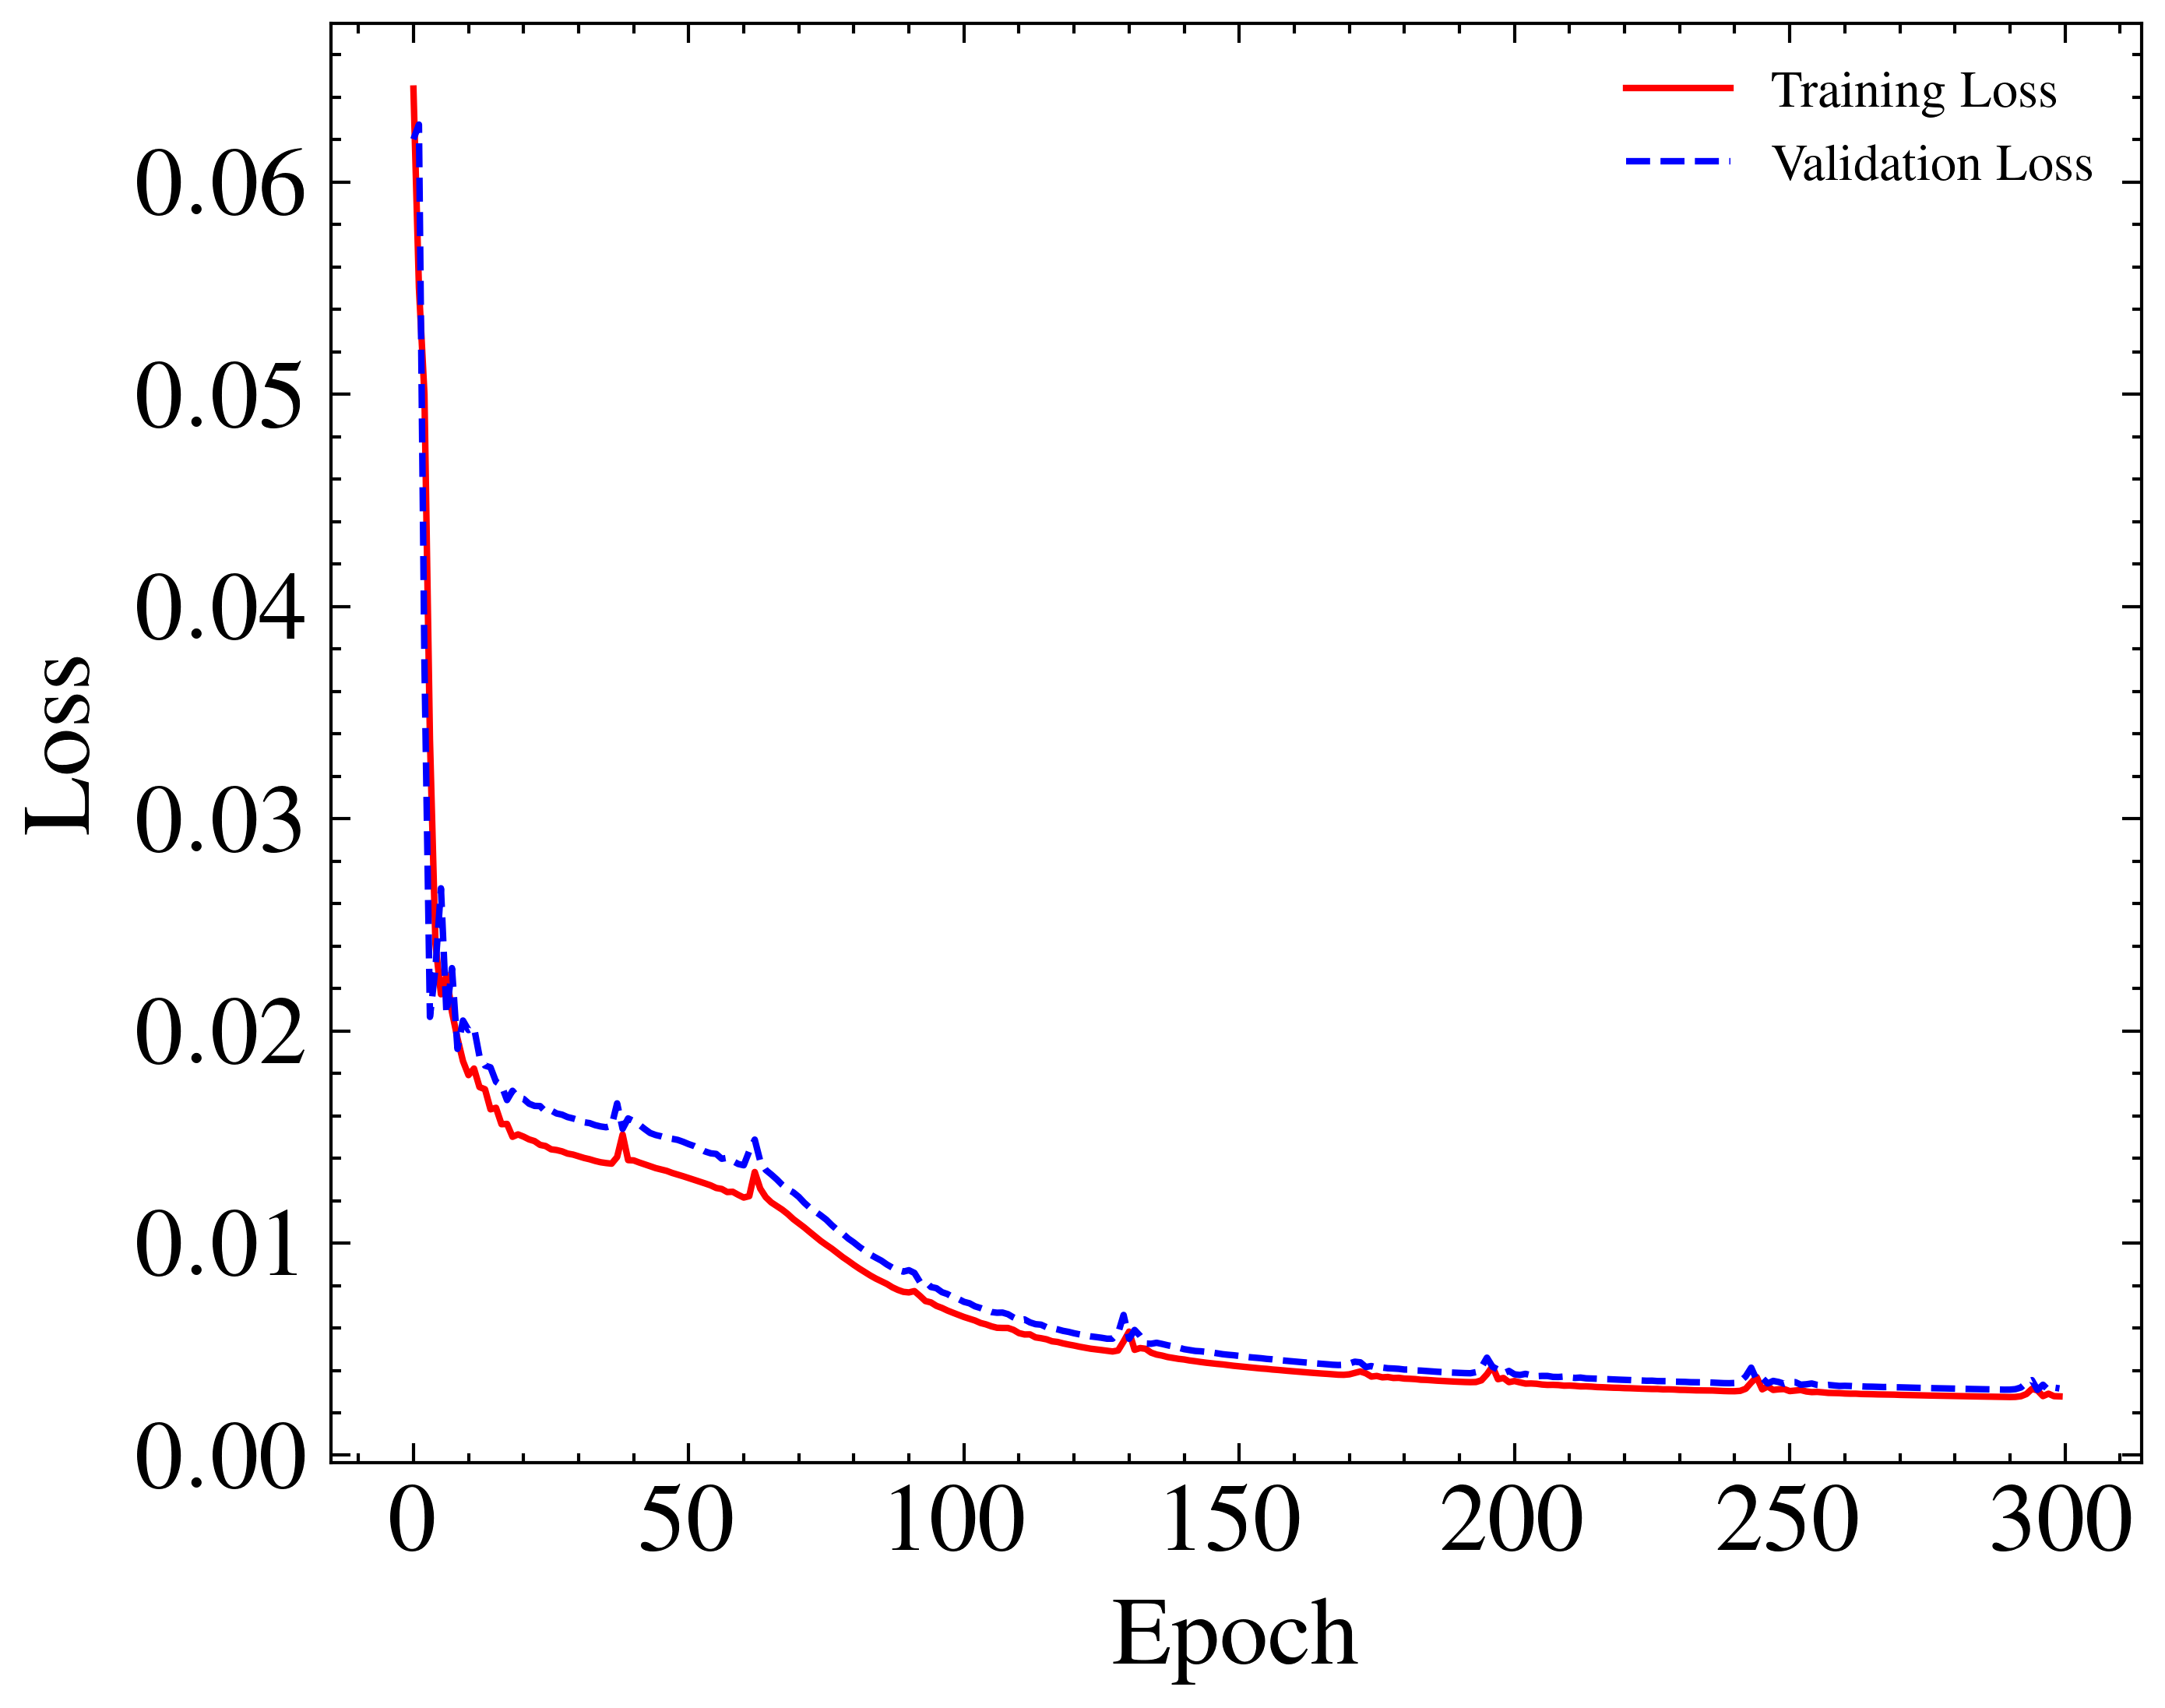

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# 配置绘图样式和参数
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()  # 清除现有内容
plt.tick_params(labelsize=15)  # 设置刻度字体大小

# 绘制损失曲线（红色和蓝色）
ax.plot(np.arange(len(train_loss)), train_loss, color='red', label='Training Loss', linewidth=1)
ax.plot(np.arange(len(valid_loss)), valid_loss, color='blue', label='Validation Loss', linewidth=1)

# 设置正体的轴标签
ax.set_xlabel(r'$\mathrm{Epoch}$', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)

# 手动设置x轴刻度
plt.xticks(np.arange(0, len(train_loss) + 5, step=50))

# 添加图例（标注）
plt.legend(fontsize=8, loc='upper right')

# 指定保存路径和文件名
plot_path = r'D:/PycharmProjects/保存的参数/指纹参数\loss_exlu.eps'

# 保存为 EPS 文件
plt.savefig(plot_path, format='eps', bbox_inches='tight')
print(f"损失图已保存到 {plot_path}")

# 展示损失图
plt.show()
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def save_and_visualize_reconstructions(model, data_loader, save_dir):
    """
    将所有验证集图像的原始和重建图像保存到指定文件夹，并展示前 5 张的对比。
    参数：
    - model: Autoencoder 模型
    - data_loader: 验证集的数据加载器
    - save_dir: 保存图像的文件夹路径（你需要提前创建好）
    """
    # 切换到评估模式
    model.eval()
    os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在则创建
    img_counter = 0  # 图像计数器

    with torch.no_grad():
        # 遍历验证集批次
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 将张量转换为 NumPy 格式，并缩放到 [0, 255]
            inputs = (inputs.cpu().numpy() * 255).astype(np.uint8)
            outputs = (outputs.cpu().numpy() * 255).astype(np.uint8)

            # 遍历批次中的每一张图像
            for i in range(inputs.shape[0]):
                # 转换为 (H, W, C) 格式（适用于 PIL）
                original_img = np.transpose(inputs[i], (1, 2, 0))
                reconstructed_img = np.transpose(outputs[i], (1, 2, 0))

                # 保存原始和重建图像
                original_path = os.path.join(save_dir, f"original_{img_counter}.png")
                reconstructed_path = os.path.join(save_dir, f"reconstructed_{img_counter}.png")

                Image.fromarray(original_img).save(original_path)
                Image.fromarray(reconstructed_img).save(reconstructed_path)

                img_counter += 1  # 更新计数器

    print(f"所有图像已保存至: {save_dir}")

    # 展示前 5 张原始和重建图像的对比
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # 加载已保存的图像
        original_img = Image.open(os.path.join(save_dir, f"original_{i}.png"))
        reconstructed_img = Image.open(os.path.join(save_dir, f"reconstructed_{i}.png"))

        # 显示原始图像
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_img)
        plt.axis('off')

        # 显示重建图像
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_img)
        plt.axis('off')

    plt.show()


# 使用你指定的文件夹路径保存和展示重建图像
save_dir = "./exluPics/"  # 将此处替换为你创建的文件夹路径
save_and_visualize_reconstructions(autoencoder, valid_loader, save_dir)

NameError: name 'autoencoder' is not defined

In [ ]:
#不管上面的，已经保存好了图像